In [1]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics
from scripts import manuscript_colors as mc

aesthetics.activate_paper_rcParams('illustrator')

# GTEX analysis

This notebook is dedicated to exploring the expression of genes affected by SVs in our tissues.

# Load SV-related data

We need to load all the SVs and the genes they affect. Thankfully, we generated this in a previous notebook, so we can just use that data.

In [2]:
# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.3.cohort_metadata.w_control_assignments.tsv.gz"
gene_ref_path = "data/updated-cwas/genes/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt"

In [3]:
gene_ref = pd.read_csv(gene_ref_path)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = sorted(set(gene_ref["value"].tolist()))
len(gene_ref)

19201

## Metadata and reference counts

Load metadata and SVs

In [4]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)

total_samples = []
for disease in ["neuroblastoma", "ewing"]:
    for cohort in ["case", "control"]:
        disease_cohort_samples = metadata[(metadata[f"{disease}_{cohort}"] == True)][
            "entity:sample_id"
        ].tolist()

        samples[disease][cohort] = disease_cohort_samples
        total_samples += disease_cohort_samples

        print(disease, cohort, len(disease_cohort_samples))

total_samples = sorted(set(total_samples))

neuroblastoma case 688
neuroblastoma control 4830
ewing case 773
ewing control 4574


In [5]:
len(total_samples)

6432

Now we load the SVs. These are reference counts generated in `cwas-gene-set-enrichment`

In [6]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")
ref_counts = ref_counts[ref_counts['gene'].isin(gene_ref)]

In [7]:
ref_counts.head(2)

,name,dose,gene,disease,sv_category,cohort
0,PedSV.2.5.2_DEL_chr1_80,0,SAMD11,neuroblastoma,coding,case
1,PedSV.2.5.2_DEL_chr1_100,1,PLEKHN1,neuroblastoma,coding,case


## Add a label for various SV traits

We add some traits to the SVs defined in these files based on the original vcf

In [8]:
sv_path = "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.3.full_cohort.analysis_samples.sites.bed.gz"
sv_cols = pd.read_csv(sv_path, sep = '\t', nrows = 0)

# in particular, we want whether the SVs are singletons in this analysis
cols_to_include = ['name', 'AC', 'gnomad_v3.1_sv_POPMAX_AF']
cols_to_include_idx = [i for i, c in enumerate(sv_cols.columns) if c in cols_to_include]

svs = pd.read_csv(sv_path, sep = '\t', usecols = cols_to_include_idx)

In [9]:
singleton_svs = svs[(svs['AC'] == 1) & (svs['gnomad_v3.1_sv_POPMAX_AF'].fillna(0) < 0.01)]['name']

In [10]:
ref_counts['global_singleton'] = ref_counts['name'].isin(singleton_svs)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files.

In [11]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/updated-cwas/svs-in-categories/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t")
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding


In [12]:
#########################
### FRAMEWORK RESULTS ###
#########################
columns = ['category_name', 'point_estimate', 'std_error', 'z_score', 'p_value']
framework_results = []
for file in glob.glob("data/updated-cwas/summary-stats/*.txt"):

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t", usecols = columns)
    data[["disease", "sv_category"]] = [
        disease,
        sv_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)
framework_results['negative_log10_p_value'] = -np.log10(framework_results['p_value'])

In [13]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/updated-cwas/schema/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split('_')[2]
    else:
        disease = suffix.split('_')[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

In [14]:
framework_schema["ewing"]["noncoding"].head(2)

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,ewing_and_osteosarcoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_muscle_skeletal,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,ewing_chromHMM15_EnhBiv,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs


# Define GTEX data

Taken from https://www.gtexportal.org/home/downloads/adult-gtex/bulk_tissue_expression

In [15]:
gtex = pd.read_csv('data/updated-cwas/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz', comment = '#', sep = '\t', skiprows = 2).rename(columns = {'Description': 'gene'})
gtex.head(2)

,Name,gene,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
1,ENSG00000227232.5,WASH7P,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,...,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743


Because we dropped genes with ENGS ids earlier, we repeat the same here, only keeping genes present in our GTF.

In [16]:
# drop ENGS ids
gtex = gtex.iloc[:, 1:]

gtex = gtex[gtex['gene'].isin(gene_ref)]

gtex = gtex.set_index('gene')

# genes need expression in at least 10% of histologies
gtex = gtex[(gtex != 0).mean(axis = 1) > 0.10]

In [17]:
gtex.shape

(17162, 54)

## Examine absolute expression

In [18]:
singleton_coding_ref_exp = ref_counts.query('dose == 1 & sv_category == "coding" & global_singleton == True')
singleton_coding_ref_exp = singleton_coding_ref_exp.merge(gtex.reset_index(), on = 'gene')

We next identify the genes that are affected by cases, controls, unique to cases, and unique to controls. For each, store the expression.

In [19]:
tpm_violin_data = []
for disease, tissue in zip(['neuroblastoma', 'ewing'], 
                           ['Adrenal Gland', 'Muscle - Skeletal']):
    
    # get the disease data - nbl or osteo
    disease_data = singleton_coding_ref_exp.query(f'disease == "{disease}"').copy()
    
    
    for cohort in ['control', 'case']:
        cohort_data = disease_data.query(f'cohort == "{cohort}"')[['gene', tissue, 'disease', 'cohort', 'name']]
        cohort_data = cohort_data.rename(columns = {tissue: 'tissue'})
        tpm_violin_data.append(cohort_data)
        
        # next, subtract out the "other" cohort to get the genes uniquely affected by SVs in this cohort
        other = 'control' if cohort == 'case' else 'case'
        other_data = disease_data.query(f'cohort == "{other}"')
        other_unique = cohort_data[~cohort_data['gene'].isin(other_data['gene'].tolist())].copy()
        other_unique['cohort'] = f'{cohort}_unique'
        tpm_violin_data.append(other_unique)
        
tpm_violin_data = pd.concat(tpm_violin_data)
tpm_violin_data['logTPM'] = np.log10(tpm_violin_data['tissue'] + 1)

In [20]:
tpm_violin_data.head(2)

,gene,tissue,disease,cohort,name,logTPM
4,DVL1,64.19010,neuroblastoma,control,PedSV.2.5.2_DEL_chr1_258,1.814182
18,NPHP4,4.73534,neuroblastoma,control,PedSV.2.5.2_DEL_chr1_1128,0.758559


Now we make this figure

In [21]:
palette = {'neuroblastoma': {'control': 'lightgrey', 
                             'case': mc.palette['neuroblastoma']['light2'],
                             'case_unique': mc.palette['neuroblastoma']['main'],
                             'control_unique': 'darkgrey'},
           'ewing': {'control': 'lightgrey', 
                     'control_unique': 'darkgrey',
                     'case': mc.palette['ewing']['light2'],
                     'case_unique': mc.palette['ewing']['main']}
          }

neuroblastoma control 0.6749915013325073 4.73142
neuroblastoma control_unique 0.693436736232442 4.936699999999999
neuroblastoma case 0.7410940569325375 5.509269999999999
neuroblastoma case_unique 0.8347531328102417 6.83523
MannwhitneyuResult(statistic=796217.0, pvalue=0.0005497022936728944)
ewing control 0.41498002937299044 2.60004
ewing control_unique 0.4268412490303142 2.67203
ewing case 0.454112800025813 2.8452
ewing case_unique 0.5190147448340754 3.303925
MannwhitneyuResult(statistic=914292.5, pvalue=0.04297085816459254)


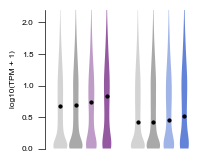

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (2.0, 1.8), gridspec_kw = {'wspace': 0}, sharey = True)

for i, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = axes[i]

    disease_data = tpm_violin_data.query(f'disease == "{disease}"')
    
    pal = palette[disease]

    violin = sns.violinplot(x = 'cohort', y = 'logTPM', data = tpm_violin_data, ax = ax,
                            order = ['control', 'control_unique', 'case', 'case_unique'], width = 0.9, linewidth=0, 
                            cut = 0, palette = pal)
    
    tpms = []
    for j, cohort in enumerate(['control', 'control_unique', 'case', 'case_unique']):
        cohort_data = disease_data.query(f'cohort == "{cohort}"')
        
        median = cohort_data['logTPM'].median()
        ax.scatter([j], [median], s = 5, color = 'black')
        
        tpms.append(cohort_data['logTPM'])
        
        print(disease, cohort, median, (10**cohort_data['logTPM']).median())

    p = stats.mannwhitneyu(tpms[1], tpms[3])
    print(p)
    
    
    ax.set_ylim([0, 2.2])
    ax.set_xlim([-1, 4])
    ax.set_ylabel('log10(TPM + 1)')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
    if i == 0:
        aesthetics.strip_axis(ax = ax, y = 'ignore', x = 'label')
        
    else:
        aesthetics.strip_axis(ax = ax, x = 'label')
        
fig.savefig('data/updated-cwas/images/expression-violin-plot-fig4d.pdf', bbox_inches = 'tight')

Repeat for other tissues, focusing on control and case unique

In [23]:
tissues = ['Adrenal Gland', 'Brain - Cortex', 'Breast - Mammary Tissue', 'Colon - Transverse', 'Heart - Left Ventricle', 
           'Kidney - Cortex', 'Liver', 'Lung', 'Muscle - Skeletal', 'Pancreas', 'Prostate', 'Skin - Sun Exposed (Lower leg)', 'Whole Blood']
tissue_names = ['Adrenal\ngland', 'Brain', 'Breast', 'Colon', 'Heart', 'Kidney', 'Liver', 'Lung', 'Skeletal\nmuscle', 'Pancreas', 'Prostate', 'Skin', 'Blood']

In [24]:
tpm_violin_data_all_tissues = []

for disease in ['neuroblastoma', 'ewing']:
    disease_data = singleton_coding_ref_exp.query(f'disease == "{disease}"').copy()
    
    for t in tissues:

        for cohort in ['control', 'case']:
            cohort_data = disease_data.query(f'cohort == "{cohort}"')[['gene', t, 'disease', 'cohort', 'name']]
            cohort_data = cohort_data.rename(columns = {t: 'value'})
            cohort_data['tissue'] = t
            tpm_violin_data_all_tissues.append(cohort_data)

            # next, subtract out the "other" cohort to get the genes uniquely affected by SVs in this cohort
            other = 'control' if cohort == 'case' else 'case'
            other_data = disease_data.query(f'cohort == "{other}"')
            other_unique = cohort_data[~cohort_data['gene'].isin(other_data['gene'].tolist())].copy()
            other_unique['cohort'] = f'{cohort}_unique'
            tpm_violin_data_all_tissues.append(other_unique)
                
tpm_violin_data_all_tissues = pd.concat(tpm_violin_data_all_tissues)
tpm_violin_data_all_tissues['logTPM'] = np.log10(tpm_violin_data_all_tissues['value'] + 1)

tpm_violin_data_all_tissues = tpm_violin_data_all_tissues[tpm_violin_data_all_tissues['cohort'].isin(['control_unique', 'case_unique'])]

In [25]:
tpm_violin_data_all_tissues.head(2)

,gene,value,disease,cohort,name,tissue,logTPM
2438,C1QTNF12,0.643373,neuroblastoma,control_unique,PedSV.2.5.2_DEL_chr1_210,Adrenal Gland,0.215736
2441,CPTP,23.840300,neuroblastoma,control_unique,PedSV.2.5.2_DEL_chr1_248,Adrenal Gland,1.395157


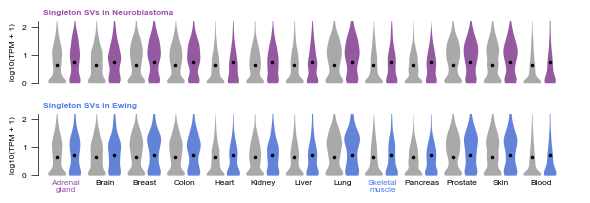

In [26]:
fig, axes = plt.subplots(2, 1, figsize = (7, 2), gridspec_kw = {'hspace': 0.5}, sharey = True)

for i, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = axes[i]

    disease_data = tpm_violin_data_all_tissues.query(f'disease == "{disease}"')
    
    pal = palette[disease]

    violin = sns.violinplot(x = 'tissue', y = 'logTPM', data = disease_data, ax = ax, hue = 'cohort', dodge = True,
                            order = tissues, width = 0.9, linewidth=0, 
                            cut = 0, palette = pal)
    
    ax.legend().remove()
    
    tpms = []
    for j, tissue in enumerate(tissues):
        for k, cohort in enumerate(['control_unique', 'case_unique']):
            cohort_data = disease_data.query(f'cohort == "{cohort}"')

            median = cohort_data['logTPM'].median()
            ax.scatter([j - 0.225 + 0.45 * k], [median], s = 3, color = 'black')
    
    ax.set_ylim([0, 2.2])
    ax.set_xlim([-0.7, len(tissues)])
    ax.set_ylabel('log10(TPM + 1)')
    
    if i == 0:
        aesthetics.strip_axis(ax = ax, y = 'ignore')
    else:
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)
        text = ax.set_xticklabels(tissue_names)
        ax.set_xlabel('')
        
        for t in text:
            if t.get_text() == 'Adrenal\ngland':
                t.set_color(mc.palette['neuroblastoma']['main'])
            elif t.get_text() == 'Skeletal\nmuscle':
                t.set_color(mc.palette['ewing']['main'])
        
    ax.text(s = 'Singleton SVs in ' + disease.capitalize(), color = mc.palette[disease]['main'], weight = 'bold', x = 0.01, y = 1.1, transform = ax.transAxes)
            
fig.savefig('data/updated-cwas/images/overall-gtex-expression-s8.pdf', bbox_inches = 'tight')

# Take a look at the Adrenal TADs

For the revision, we're going to compare expression of genes in adrenal TADs vs outside adrenal TADs across various tissues. Let's see what this looks like.

In [27]:
adrenal_tad_genes = pd.read_csv('data/genes_in_adrenal_TADs_7_4_24.tsv', sep = '\t')['value'].tolist()

adrenal_tad_genes = [g for g in adrenal_tad_genes if g in gtex.index]

# get the genes affected by singleton SVs in neuroblastoma
singleton_genes = singleton_coding_ref_exp.query('disease == "neuroblastoma" & cohort == "case"')
singleton_genes = singleton_genes['gene'].drop_duplicates().to_list()

This only uses GTEX data, nothing to do with our SVs

In [28]:
tad_expression = gtex.loc[adrenal_tad_genes].reset_index().melt(id_vars = 'gene')
tad_expression['type'] = 'tad'

non_tad_genes = [g for g in gtex.index if g not in adrenal_tad_genes]
nontad_expression = gtex.loc[non_tad_genes].reset_index().melt(id_vars = 'gene')
nontad_expression['type'] = 'non_tad'

singleton_expression = gtex.loc[singleton_genes].reset_index().melt(id_vars = 'gene')
singleton_expression['type'] = 'singleton'

grouped_data = pd.concat([tad_expression, nontad_expression, singleton_expression])

In [29]:
rand_genes = np.random.choice(adrenal_tad_genes, 705, replace = False)
gtex.loc[rand_genes, 'Adrenal Gland'].mean()

27.985254149886526

In [30]:
grouped_data['logTPM'] = np.log10(grouped_data['value'] + 1)

In [31]:
gtex.loc[adrenal_tad_genes, 'Adrenal Gland'].median(), gtex.loc[non_tad_genes, 'Adrenal Gland'].median(), gtex.loc[singleton_genes, 'Adrenal Gland'].median()

(6.89811, 5.57506, 4.83493)

In [32]:
tissues = ['Adrenal Gland', 'Brain - Cortex', 'Breast - Mammary Tissue', 'Colon - Transverse', 'Heart - Left Ventricle', 
           'Kidney - Cortex', 'Liver', 'Lung', 'Muscle - Skeletal', 'Pancreas', 'Prostate', 'Skin - Sun Exposed (Lower leg)', 'Whole Blood']
tissue_names = ['Adrenal\ngland', 'Brain', 'Breast', 'Colon', 'Heart', 'Kidney', 'Liver', 'Lung', 'Skeletal\nmuscle', 'Pancreas', 'Prostate', 'Skin', 'Blood']

Text(0, 0.5, 'log10(TPM + 1)')

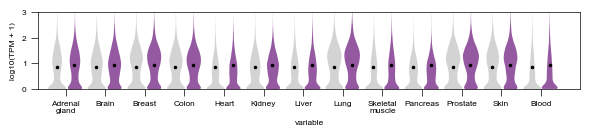

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (7, 1))
pal = {'non_tad': 'lightgrey',
       'tad': "#9D4DAD"}
violin = sns.violinplot(x = 'variable', y = 'logTPM', data = grouped_data, ax = ax, hue = 'type', dodge = True,
                        order = tissues, hue_order = ['non_tad', 'tad'], width = 0.9, linewidth=0, 
                        cut = 0, palette = pal)

ax.legend().remove()
ax.set_xticklabels(tissue_names)
    
tpms = []
for j, tissue in enumerate(tissues):
    for k, subset in enumerate(['non_tad', 'tad']):
        cohort_data = grouped_data.query(f'type == "{subset}"')

        median = cohort_data['logTPM'].median()
        ax.scatter([j - 0.225 + 0.45 * k], [median], s = 3, color = 'black')

ax.set_ylim([0, 3])
ax.set_xlim([-0.7, len(tissues)])
ax.set_ylabel('log10(TPM + 1)')

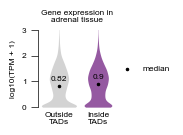

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (1, 1))
pal = {'non_tad': 'lightgrey',
       'tad': "#9D4DAD"}
violin = sns.violinplot(x = 'type', y = 'logTPM', data = grouped_data.query('variable == "Adrenal Gland"'), ax = ax,
                        order = ['non_tad', 'tad'], width = 0.9, linewidth=0, 
                        cut = 0, palette = pal)

# ax.legend().remove()
# ax.set_xticklabels([])
    
tpms = []
for k, subset in enumerate(['non_tad', 'tad']):
    cohort_data = grouped_data.query(f'variable == "Adrenal Gland" & type == "{subset}"')

    median = cohort_data['logTPM'].median()
    ax.scatter([k], [median], s = 3, color = 'black', label = 'median' if k == 0 else '')
    ax.text(s = np.round(median, 2), x = k, y = median + 0.3, va = 'center', ha = 'center')

ax.legend(bbox_to_anchor = (0.95, 0.5))
ax.set_ylim([0, 3])
ax.set_ylabel('log10(TPM + 1)')
aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')
ax.set_title('Gene expression in\nadrenal tissue')
ax.set_xlabel('')
ax.set_xticklabels(['Outside\nTADs', 'Inside\nTADs'])
fig.savefig('images/revision-adrenal-tad-vs-nontad.png', dpi = 300, bbox_inches = 'tight')

In [35]:
test = singleton_coding_ref_exp.query('disease == "neuroblastoma" & cohort == "case"')['Adrenal Gland']
(np.log10(test + 1)).mean()

0.7579226583434786

In [36]:
grouped_data.groupby(['variable', 'type'])['logTPM'].median().tail(10)

variable     type     
Thyroid      tad          1.122193
Uterus       non_tad      1.030212
             singleton    1.023669
             tad          1.127008
Vagina       non_tad      1.001191
             singleton    0.950974
             tad          1.089654
Whole Blood  non_tad      0.384088
             singleton    0.286412
             tad          0.460687
Name: logTPM, dtype: float64